Trying to make inferences on the motor prediction problem, rescaling back outputs to match actual motors ticks

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
from fae import dataset_loader
from fae.training_utils import Experiment, ExperimentSet

import numpy as np
import tensorflow as tf

import keras

from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam, SGD
from keras import backend as K

np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:.2f}'.format})

Using TensorFlow backend.


In [3]:
m=load_model("models/fae.mp.20191023.bin")

W1024 20:23:20.578539 139721777482752 deprecation_wrapper.py:119] From /home/yves/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1024 20:23:20.591736 139721777482752 deprecation_wrapper.py:119] From /home/yves/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1024 20:23:20.648259 139721777482752 deprecation_wrapper.py:119] From /home/yves/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1024 20:23:20.648996 139721777482752 deprecation_wrapper.py:119] From /home/yves/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1024 20:23:20.

In [4]:
inputs,outputs, scale_factors = dataset_loader.load_dataset("../../..//datasets/real/2019-10-18/raw/",
                                                            return_scale_parameters=True)[2:]

In [5]:
pred = m.predict(np.array([inputs[-1]]))[0]
print(pred)

[0.23 0.47 0.50 0.59]


In [13]:
scale_factors[3]

[(0, -13250.0, 31639.0),
 (1, -14003.0, 29893.0),
 (2, -21997.0, 36617.0),
 (3, -15090.0, 29295.0)]

In [14]:
def adjust(val, sf):
    sfd = dict()
    retval = list()
    for s in sf:
        sfd[s[0]]=s[1:]
    for i in range(len(val)):
        offset, scale = sfd.get(i, (0,1.0))
        retval.append(val[i]*scale+offset)
    return retval        

In [15]:
print(adjust(pred, scale_factors[3]))

[-5952.596885249019, 169.98292562365532, -3645.063023686409, 2186.986184120178]


Pretty straightforward actually...

But I can't use the MP model as I made it. I want to only give XYZ instructions to the model, so I can't have `[quat_src, pos_src, quat_dst, pos_dst]` as input, I need to just have `[quat_src, pos_src, pos_dst]`. Let's retrain that.

In [16]:
def pprint(iteratable):
    for i in iteratable:
        print(i)

In [17]:
es = ExperimentSet()
es.random_params({
        'dropout' : [0],
        'core_size' : [512, 256],
        'num_layers' : [1, 2, 3],
        'activation' : ["relu"],
        'input_size' :[10]
    },
    6)


pprint(es.params_set)

{'dropout': 0, 'core_size': 256, 'num_layers': 2, 'activation': 'relu', 'input_size': 10}
{'dropout': 0, 'core_size': 512, 'num_layers': 3, 'activation': 'relu', 'input_size': 10}
{'dropout': 0, 'core_size': 512, 'num_layers': 2, 'activation': 'relu', 'input_size': 10}
{'dropout': 0, 'core_size': 512, 'num_layers': 1, 'activation': 'relu', 'input_size': 10}


In [18]:
es.create_experiments(fit_params = { 'batch_size':10000,
                            'epochs':1000,
                            'verbose':0,
                            'shuffle':True,
                            'validation_split':0.1},
            compile_params={'loss'    :'mean_squared_error',
                            'metrics' :['mean_squared_error']},
            data_loader = 'fae.dataset_loader.load_dataset_mmp("../../..//datasets/real/2019-10-18/raw/", shuffle=False)[:2]',
            set_name="es1")

In [19]:
es.run()

--------------------
es1 dropout=0 core_size=256 num_layers=2 activation=relu input_size=10 
Epoch: 100/1000 ...  - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch: 200/1000 ...  - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch: 300/1000 ...  - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch: 400/1000 ...  - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch: 500/1000 ...  - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch: 600/1000 ...  - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch: 700/1000 ...  - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch: 800/1000 ...  - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0013 - va

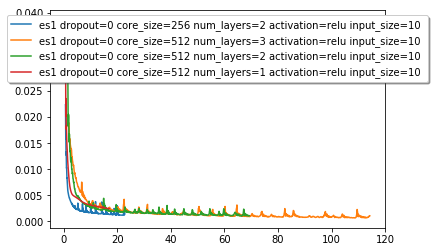

In [20]:
es.plot(trim_left=10)

In [21]:
# Any will do...

model = es.experiments[1].model
model.save("models/fae.mmp.20191024.bin")

In [22]:
inputs,outputs, scale_factors = dataset_loader.load_dataset_mmp("../../..//datasets/real/2019-10-18/raw/",
                                                            return_scale_parameters=True)

In [23]:
adjust(model.predict(np.array([inputs[0]])), scale_factors[1])

[array([-7031.85, 3363.01, 2360.95, 11038.83], dtype=float32)]

In [24]:
offsets = np.array(scale_factors[0][3:])[...,1]
scales =  np.array(scale_factors[0][3:])[...,2]

In [25]:
scale_factors

([(4, -147.926529, 387.173253),
  (5, -89.423148, 349.30483300000003),
  (6, -1103.013905, 403.418491),
  (7, -147.926529, 387.173253),
  (8, -89.423148, 364.151892),
  (9, -1103.013905, 403.418491)],
 [(0, -13250.0, 31639.0),
  (1, -14003.0, 29893.0),
  (2, -21997.0, 36617.0),
  (3, -15090.0, 29295.0)])

In [26]:
art = np.array(inputs[10])

In [27]:
art[-3]=art[-6]
art[-2]=art[-5]
art[-1]=art[-4]

In [28]:
adjust(model.predict(np.array([art])), scale_factors[1])

[array([-256.94, 1922.27, 5165.38, 6071.19], dtype=float32)]

In [29]:
art

array([0.65, -0.19, -0.32, 0.66, 0.72, 0.52, 0.39, 0.72, 0.52, 0.39])

In [30]:
adjust(model.predict(np.array([inputs[10]])), scale_factors[1])

[array([-7010.15, 4664.84, 8331.18, -1099.19], dtype=float32)]

In [31]:
inputs[10]

array([0.65, -0.19, -0.32, 0.66, 0.72, 0.52, 0.39, 0.49, 0.56, 0.38])

In [32]:
def give_motor_orders(model, sf, current_pos, delta):
    in_offsets = [0]*10
    in_scales = [1.0]*10
    for i,o,s in scale_factors[0]:
        in_offsets[i]=o
        in_scales[i]=s
    in_offsets = np.array(in_offsets)
    in_scales = np.array(in_scales)
    
    out_offsets = np.array(scale_factors[1])[...,1]
    out_scales =  np.array(scale_factors[1])[...,2]
    
    model_input = np.array(current_pos)
    model_input = np.concatenate((model_input, np.array(current_pos[-3:])+np.array(delta)))
    model_input = (model_input - in_offsets)/in_scales
    
    out=model.predict(np.array([model_input]))[0]
    nout = out*out_scales + out_offsets
    return nout

In [33]:
give_motor_orders(model, scale_factors, inputs[20][:7], [10.0, 0.0, 0.0])

array([10394.74, -17728.29, -6061.32, 35073.22])

In [34]:
give_motor_orders(model, scale_factors, inputs[20][:7], [100.0, 0.0, 0.0])

array([11690.99, -13859.15, -7780.64, 26581.33])

In [35]:
series = [list(), list(), list(), list(), list()]
for k in range(-500,500):
    arr = give_motor_orders(model, scale_factors, inputs[20][:7], [k, 0.0, 0.0])
    series[0].append(k)
    for i in range(4):
        series[i+1].append(arr[i])

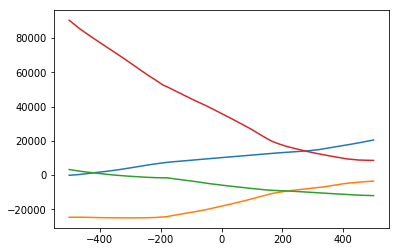

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(1,5):
    ax.plot(series[0], series[i])

In [37]:
t, p = dataset_loader.parse_file("../../..//datasets/real/2019-10-18/raw/coords-2019-10-18-20-46-54.txt")
pairs = dataset_loader.create_training_pairs(t,p)
delta_ticks = np.array(pairs)[..., 7:11]

In [38]:
delta_ticks

array([[5366.00, 6202.00, 10.00, 2841.00],
       [5504.00, 6042.00, 189.00, 2673.00],
       [5643.00, 5882.00, 368.00, 2505.00],
       ...,
       [-93.00, -79.00, -10740.00, -1362.00],
       [-295.00, 75.00, -10627.00, -1126.00],
       [-497.00, 229.00, -10514.00, -890.00]])

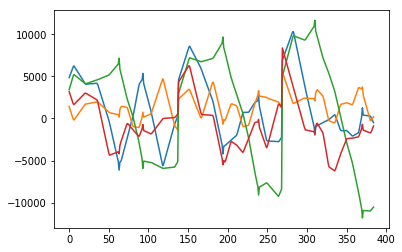

In [39]:
series = [list(), list(), list(), list()]
for v in delta_ticks:
    for i in range(4):
        series[i].append(v[i])
fig, ax = plt.subplots()
for i in range(0,4):
    ax.plot(series[i][250:])

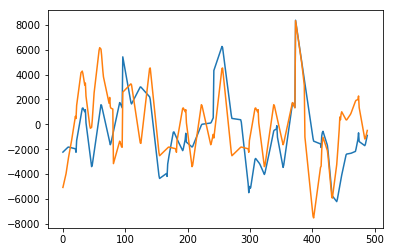

In [40]:
d=146
fig, ax = plt.subplots()
ax.plot(series[3][d:])
ax.plot([series[3][i] - series[3][i-d] for i in range(d, len(series[3]))])